<a href="https://colab.research.google.com/github/abuzarmahmood/pymcon_bayesian_changepoint/blob/master/Bayesian_Changepoint_Zoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Execute only if executing in Google Colab
if IN_COLAB:
    !pip install --upgrade pip
    !pip install --upgrade pymc==5.9.0 numpyro==0.13.2
    !git clone https://github.com/abuzarmahmood/pymcon_bayesian_changepoint.git
    !mv pymcon_bayesian_changepoint/src .

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os
import pymc as pm
import pylab as plt
from scipy import stats
import pytensor.tensor as tt
import seaborn as sns
import multiprocessing

In [4]:
from src import get_data, gen_plots

# ==== Prelude ====

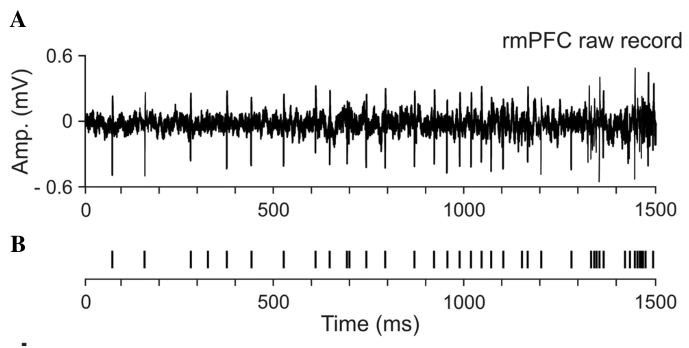

**REF**: Fig. 2, Caro-Martín, C.R., Delgado-García, J.M., Gruart, A. et al. Spike sorting based on shape, phase, and distribution features, and K-TOPS clustering with validity and error indices. Sci Rep 8, 17796 (2018). https://doi.org/10.1038/s41598-018-35491-4

- If you record voltage from the brain, neurons show sharp "spikes" in their activity when they are active/on (**panel A**)
- Many neurons display reliable patterns of activity in response to an event or stimulus (e.g. sugar water on the tongue, or seeing a specific object).
- To visualize these patterns of activity, we can denote the times at which the neuron is active in a "spike train" (**panel B**). This is a timeseries of binary values indicating when the neuron was active.
- Analyzing the dynamics of the spike trains can inform us about which brain regions are active for a specific process (e.g. processing taste), and at what times.

# ==== Load Data ====

- We will load data from an extracellular recording from the Gustatory Cortex (see **REF** below) involving 30 repeated deliveries of a single taste (30 trials), 29 simultanesouly recorded neurons, and 7000ms of spike trains around the time of taste delivery (2000ms before, and 5000ms after).
- We will also load an estimate of the instantaneous emission rate, purely for visualization.

- **REF**: Katz, D. B., et al. “Dynamic and Multimodal Responses of Gustatory Cortical Neurons in Awake Rats.” The Journal of Neuroscience: The Official Journal of the Society for Neuroscience, vol. 21, no. 12, June 2001, pp. 4478–89. PubMed, https://doi.org/10.1523/JNEUROSCI.21-12-04478.2001.

In [5]:
# Raw spike trains (binary)
spike_dat = np.load(os.path.join('data/spikes.npy'))
# Estimated instantaneous (firing) rate (continuous)
firing_dat = np.load(os.path.join('data/firing.npy'))
# Rearrange firing_dat to have same dims as spike_dat
firing_dat = np.swapaxes(firing_dat,0,1)

In [6]:
print(f'{spike_dat.shape} = (Trials, Neurons, Time)')

(30, 29, 7000) = (Trials, Neurons, Time)


In [7]:
print(f'{firing_dat.shape} = (Trials, Neurons, Time)')

(30, 29, 271) = (Trials, Neurons, Time)


#### Visualize data

Plot spike-trains and firing rates for some neurons

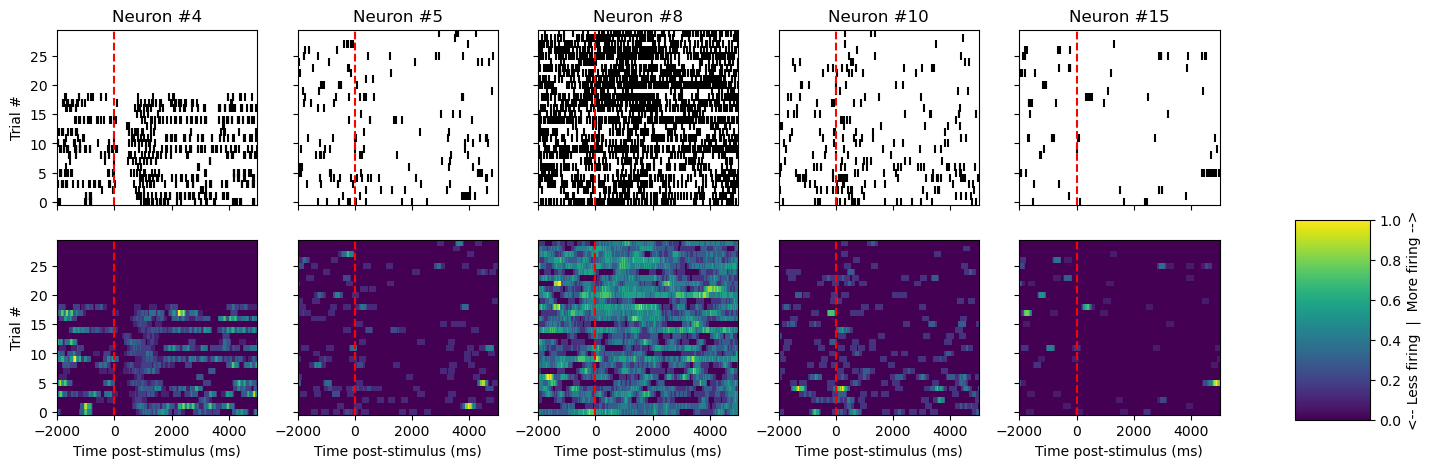

In [51]:
plot_n = 5
stim_t = 0
spike_t_vec = np.arange(-2000, 5000)
firing_t_vec = np.linspace(spike_t_vec[0], spike_t_vec[-1], firing_dat.shape[-1])
plot_inds = np.random.choice(np.arange(spike_dat.shape[1]), plot_n, replace=False)
plot_inds = np.sort(plot_inds)
fig,ax = plt.subplots(2, plot_n, 
                      sharex=True, sharey=True,
                     figsize = (15,5))

# Note: Time for spikes and firing is not on same scale

for i in range(plot_n):
    this_spike = spike_dat[:, plot_inds[i]]
    this_firing = firing_dat[:, plot_inds[i]]
    spike_x, spike_y = np.where(this_spike)[::-1]
    # Convert spike_inds to time relative to stimulus delivery
    spike_x = spike_t_vec[spike_x]
    ax[0,i].scatter(spike_x, spike_y, color = 'k', marker = '|')
    im = ax[1,i].pcolormesh(firing_t_vec, np.arange(len(this_firing)), this_firing)
    ax[1,i].set_xlabel('Time post-stimulus (ms)');
    ax[0,i].set_title(f'Neuron #{plot_inds[i]}')
    ax[0,i].axvline(stim_t, color = 'red', linestyle = '--')
    ax[1,i].axvline(stim_t, color = 'red', linestyle = '--')
cax = fig.add_axes([0.95, 0.1, 0.05, 0.4])
fig.colorbar(im, cax=cax, label = '<-- Less firing  |  More firing -->')
ax[0,0].set_ylabel('Trial #');
ax[1,0].set_ylabel('Trial #');

# === Single Poisson Changepoint ===

- We first analyze spike-trains using a single-changepoint model to see when changes occur.
- We will infer when changes in the neural activity happen on-average, averaging across trials.

Parent example: </br>
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC_current.ipynb

#### Get, and plot data

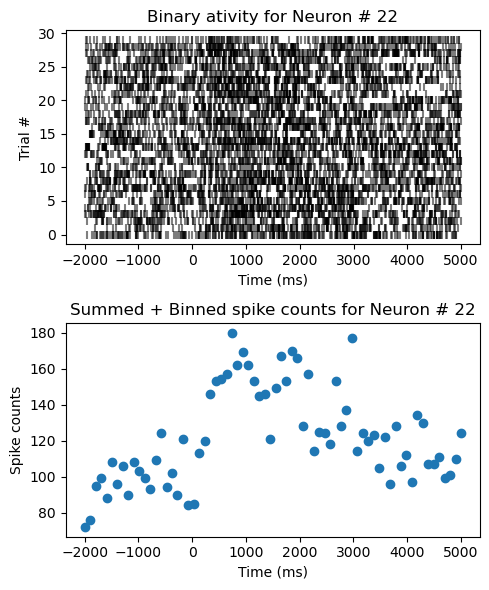

In [80]:
# Convert binary data to poisson

# Extract data for waned neuron
nrn_ind = 22
raw_data = spike_dat[:, nrn_ind]

# Sum binary spikes across trials, and bin in time to get timeseries of counts
bin_size = 100
poisson_data = np.reshape(raw_data, (raw_data.shape[0], -1, bin_size)).sum(axis=(0,-1))
time_vec = np.linspace(-2000, 5000, len(poisson_data))

# Plot raw and processed data
fig,ax  = plt.subplots(2,1, figsize = (5,6))
spike_x, spike_y = np.where(spike_dat[:, nrn_ind])[::-1]
ax[0].scatter(spike_t_vec[spike_x], spike_y, color = 'k', marker = '|', alpha = 0.5)
ax[0].set_xlabel('Time (ms)');
ax[0].set_ylabel('Trial #');
ax[0].set_title(f'Binary ativity for Neuron # {nrn_ind}');

ax[1].scatter(time_vec, poisson_data);
ax[1].set_xlabel('Time (ms)');
ax[1].set_ylabel('Spike counts');
ax[1].set_title(f'Summed + Binned spike counts for Neuron # {nrn_ind}');

plt.tight_layout()

#### Construct simple Poisson Model

In [86]:
with pm.Model() as simple_model:

    # Uniform Prior on switchpoint location --> We think it can be anywhere
    # between the minimum and maximum times
    # "testval" = Our guess of where it could be, useful if dataset is small
    switchpoint = pm.DiscreteUniform(
        "switchpoint", lower=time_vec.min(), upper=time_vec.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to time_vec before and after current
    # While statement (switchpoint >= time_vec) is false, use early rate
    # if true, use late rate
    rate = pm.math.switch(switchpoint >= time_vec, early_rate, late_rate)

    # Data modelled as poisson distribution with the given rate
    counts = pm.Poisson("counts", rate, observed=poisson_data)

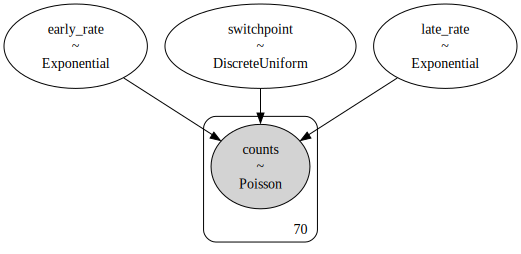

In [87]:
# Plot the graph for the model
pm.model_to_graphviz(simple_model)

In [88]:
# Run inference on the model
with simple_model:
    trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


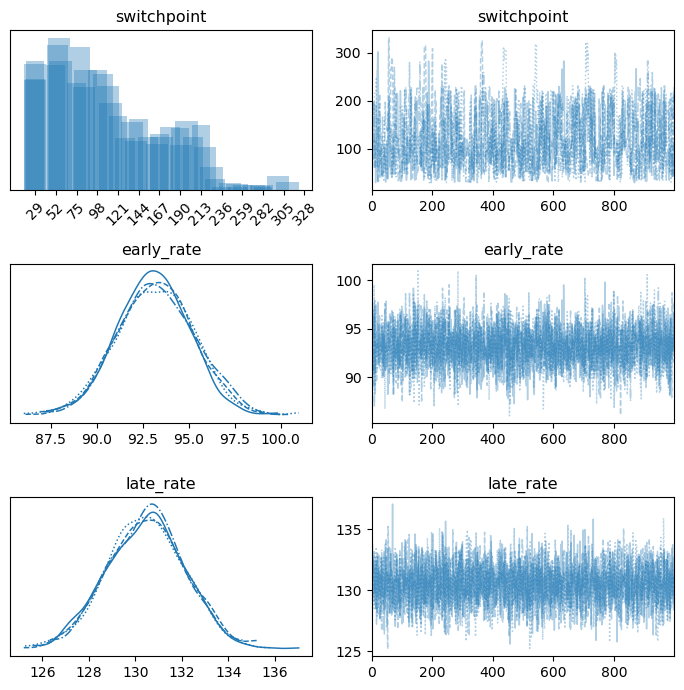

In [89]:
# Plot inferred distributions
ax = pm.plot_trace(trace, figsize = (7,7));
plt.setp(ax[0,0].xaxis.get_majorticklabels(), rotation=45);
plt.tight_layout()

Sampling: [counts]


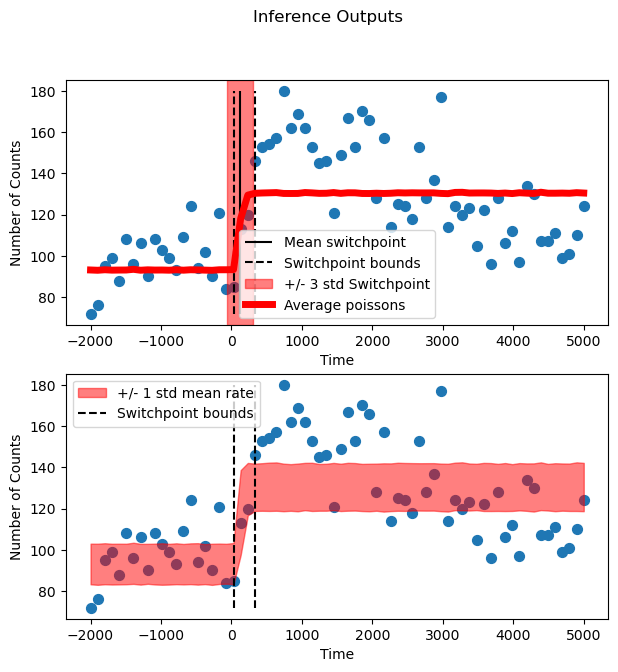

In [90]:
# Sample OBSERVATIONS from the posterior distribution, using the paramters as determined by the trace
gen_plots.gen_simple_plots(time_vec, poisson_data, simple_model, trace, figsize = (7,7))

# === Bernoulli Mixture Emissions ===

- The "on-average" picture above assumes that we can average across all trials and get a good picture of the data. While this is true in most cases, in many cases, data for all trials DO NOT belong to the same set (see **REF** below).
- In such cases, we need to account for this inhomogeneity and treat these sets of trials differently, else, our model will likely perform poorly (see **Related Reading** below).
- This would be easy if we knew what the different trials were, but in many cases, we don't have any a-priori knowledge about which trials may be different.
- Hence, a principled way to address this issue is to use a changepoint model with a mixture of emissions. 

- **REF** : Humphries, Mark D. “Spike-Train Communities: Finding Groups of Similar Spike Trains.” Journal of Neuroscience, vol. 31, no. 6, Feb. 2011, pp. 2321–36. www.jneurosci.org, https://doi.org/10.1523/JNEUROSCI.2853-10.2011.
- **Related Reading**: https://medium.com/@abuzar_mahmood/changepoint-detection-for-inhomogeneous-timeseries-mixture-emissions-in-pymc3-2301f76c0064

In [92]:
# Convert binary data to poisson

# Extract data for waned neuron
nrn_ind = 8
raw_data = spike_dat[:, nrn_ind]

# Since activity is sparse bin in time to compress data
# Digitize for counts > 0
bin_size = 10
bernoulli_data = np.reshape(raw_data, (raw_data.shape[0], -1, bin_size)).sum(axis=-1) > 0
time_vec = np.linspace(0, raw_data.shape[-1], poisson_data.shape[-1])

In [94]:
bernoulli_data.shape

(30, 700)

In [ ]:
# Plot raw and processed data
fig,ax  = plt.subplots(1,1, figsize = (3,3))
ax.scatter(*np.where(bernoulli_data[:, nrn_ind])[::-1], color = 'k', marker = '|', alpha = 0.5)
ax.set_xlabel('Time (ms)');
ax.set_ylabel('Trial #');
ax.set_title(f'Binary ativity for Neuron # {nrn_ind}');

plt.tight_layout()

- In the plots above, we can see changes across both time, and across trials.
- **Roughly, trials after #15 exhibit higher emission rates from 2000-4000ms than earlier trials.**
- This means that if we fit a changepoint model for multiple trials, we can not assume constant emissions.

In [27]:
# Specify parameters
length = len(time_vec) # Length of data
idx = np.arange(length) # Index across time
n_states = 3 # Number of model states
n_trials = len(poisson_data) # Number of trials
n_components = 2 # Number of mixtures in model, **NOTE** : This is a consdtant for the current model

In [28]:
# Calculate mean emission values to initialize parameters
mean_vals = np.array(
    [np.mean(x,axis=(0,-1)) for x in np.array_split(poisson_data,n_states,axis=-1)]
).T

In [29]:
with pm.Model() as model:
    alpha_w = pm.Gamma('alpha_w',7.5,1,shape = n_components)
    w = pm.Dirichlet('w', a=alpha_w, shape = (n_trials,n_components))

    alphas = pm.HalfCauchy('alphas',5,shape=(2,3))
    betas = pm.HalfCauchy('betas',5,shape=(2,3))
    clust0_lambda = pm.math.stack([pm.Beta('l00',alphas[0,0], betas[0,0]),
                             pm.Beta('l01',alphas[0,1], betas[0,1]),
                             pm.Beta('l02',alphas[0,2], betas[0,2])])
    clust1_lambda = pm.math.stack([pm.Beta('l10',alphas[1,0], betas[1,0]),
                             pm.Beta('l11',alphas[1,1], betas[1,1]),
                             pm.Beta('l12',alphas[1,2], betas[1,2])])
    lambdas = pm.math.stack([clust0_lambda,clust1_lambda])

    #################################################
    a = pm.HalfCauchy('a_tau', 3., shape = n_states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = n_states - 1)

    even_switches = np.linspace(0,1,n_states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b,
                         shape = (n_trials,n_states-1))

    tau = pm.Deterministic('tau',
            idx.min() + (idx.max() - idx.min()) * tau_latent)

    #################################################

    weight_stack = pm.math.sigmoid(idx[np.newaxis, np.newaxis, :]-tau[:,:,np.newaxis])
    weight_stack_shape = weight_stack.eval().shape
    weight_stack = pm.math.concatenate(
        [np.ones(
            (weight_stack_shape[0],1,weight_stack_shape[-1])
            ),weight_stack],
        axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = pm.math.concatenate(
        [inverse_stack,
         np.ones(
            (weight_stack_shape[0],1,weight_stack_shape[-1])
            )
         ],
        axis=1)
    weight_stack = np.multiply(weight_stack,inverse_stack)

    #################################################
    selected_lambdas = pm.math.dot(w,lambdas)[:,:,np.newaxis]
    lambda_ = pm.math.sum(selected_lambdas*weight_stack,axis=1)
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=poisson_data)

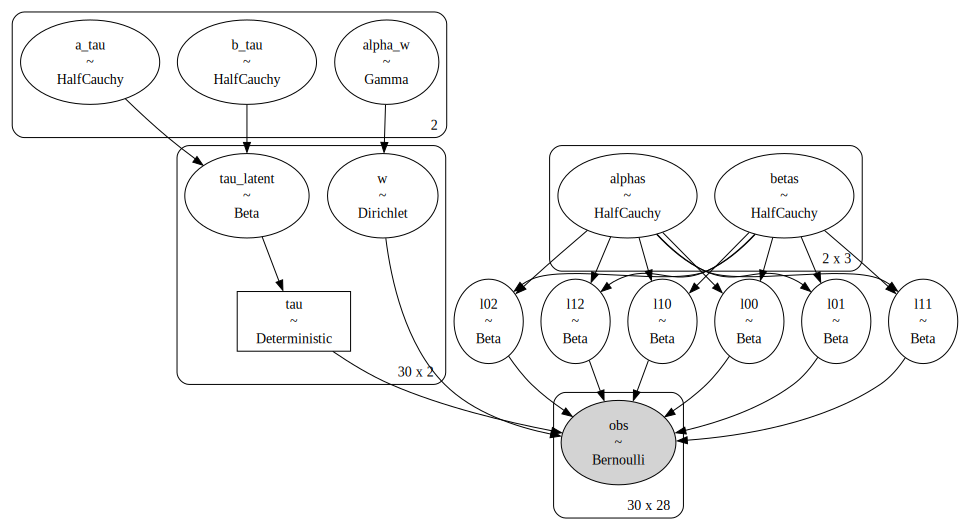

In [30]:
pm.model_to_graphviz(model)

In [31]:
with model:
    trace = pm.sample(nuts_sampler="numpyro", chains = 4, cores = 4)

/home/abuzarmahmood/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:49.940445
Sampling...


Compiling.. :   0%|                                                                       | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                     | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                       | 0/2000 [00:00<?, ?it/s]


  0%|                                                                                     | 0/2000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                                    | 0/2000 [00:14<?, ?it/s]


Running chain 3:   0%|                                                                    | 0/2000 [00:14<?, ?it/s]

Running chain 0:   0%|                                                                    | 0/2000 [00:14<?, ?it/s]

Running chain 1:  50%|███████████████████████████▌                           | 1000/2000 [00:14<00:00, 9609.54it/s]


Running chain 3: 100%|██████████████████████████████████████

Sampling time =  0:00:15.688692
Transforming variables...
Transformation time =  0:00:00.460123


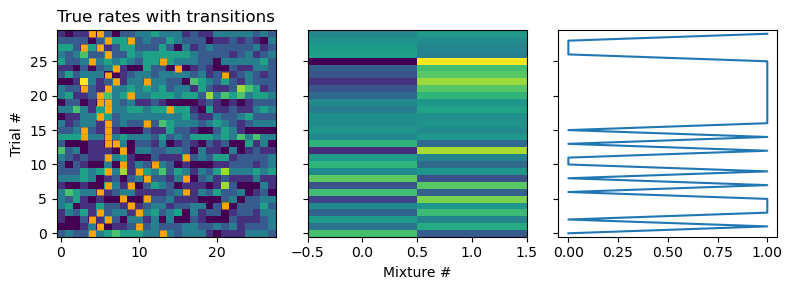

In [45]:
tau_samples = trace['posterior']['tau']
int_tau = np.vectorize(int)(tau_samples)
mode_tau = stats.mode(int_tau,axis=0)[0][0]
hist_tau = np.array([np.histogram(trial, bins = np.arange(20))[0] for trial in int_tau.swapaxes(0,1)])

w_samples = trace['posterior']['w'].values
w_samples_long = np.reshape(w_samples,(-1,w_samples.shape[-1]))
mean_w = np.mean(w_samples,axis=(0,1))
categorical_w = np.argmax(mean_w,axis=-1)

fig,ax = plt.subplots(1,3,figsize=(8,3), sharey=True)
ax[0].set_title('True rates with transitions')
ax[0].imshow(poisson_data,aspect='auto',origin='lower', cmap = 'viridis')
for trial,val in enumerate(mode_tau):
    ax[0].vlines(val, trial-0.5,trial+0.5, linewidth = 5, color='orange')
ax[1].imshow(mean_w,aspect='auto',origin='lower');
ax[1].set_xlabel('Mixture #')
ax[0].set_ylabel('Trial #')
ax[2].plot(categorical_w, np.arange(len(categorical_w)))
plt.tight_layout()

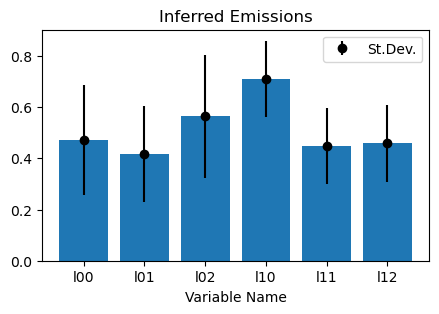

In [34]:
emission_var_names = [['l00','l01','l02'],['l10','l11','l12']]
emission_var_names_flat = [x for y in emission_var_names for x in y]
emission_values = np.stack([[trace['posterior'][x] for x in this_comp] \
        for this_comp in emission_var_names])
mean_emissions = emission_values.mean(axis=(2,3))
std_emissions = emission_values.std(axis=(2,3))

fig,ax = plt.subplots(1,1, figsize=(5,3));
ax.errorbar(emission_var_names_flat, mean_emissions.flatten(), 
               yerr = std_emissions.flatten(), fmt = 'o', c = 'k',
               label = 'St.Dev.');
ax.legend()
ax.bar(emission_var_names_flat, mean_emissions.flatten());
ax.set_title('Inferred Emissions');
ax.set_xlabel('Variable Name');

# === Dirichlet Process Changepoint ===

Related reading: https://medium.com/@abuzar_mahmood/probabilistically-determining-the-number-of-components-for-unsupervised-learning-e1c3c4a82082

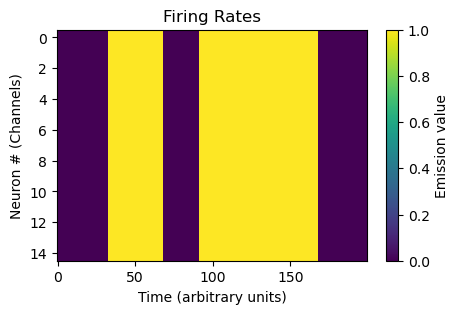

In [22]:
# Max number of states in the model
max_states = 15

# Some poisson spiking
length = 200
n_states = 5
n_neurons = 15

true_r, true_tau, true_lambda = get_data.return_dirichlet_process_data(length, n_states, n_neurons, seesaw_emissions=True)

fig,ax = plt.subplots(figsize = (5,3))
im = ax.imshow(true_r,aspect='auto', interpolation='nearest')
plt.colorbar(im, label = 'Emission value')
ax.set_xlabel('Time (arbitrary units)');
ax.set_ylabel("Neuron # (Channels)");
ax.set_title('Firing Rates');

In [23]:
def stick_breaking(beta):
    portion_remaining = pm.math.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [24]:
# Index vector timebins in data
idx = np.arange(length)

with pm.Model() as dpp_model:

    # ===================
    # Emissions Variables
    # ===================
    lambda_latent = pm.Normal('lambda',
                    mu = 0, sigma = 10,
                    shape = (n_neurons, max_states))

    # =====================
    # Changepoint Variables
    # =====================

    # Hyperpriors on alpha
    a_gamma = pm.Gamma('a_gamma',10,1)
    b_gamma = pm.Gamma('b_gamma',1.5,1)

    # Concentration parameter for beta
    alpha = pm.Gamma('alpha', a_gamma, b_gamma)

    # Draw beta's to calculate stick lengths
    beta = pm.Beta('beta', 1, alpha, shape = max_states)

    # Calculate stick lengths using stick_breaking process
    w_raw = pm.Deterministic('w_raw', stick_breaking(beta))

    # Make sure lengths add to 1, and scale to length of data
    w_latent = pm.Deterministic('w_latent', w_raw / w_raw.sum())
    tau = pm.Deterministic('tau', tt.cumsum(w_latent * length)[:-1])

    # Weight stack to assign lambda's to point in time
    weight_stack = pm.math.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    weight_stack = pm.math.concatenate([np.ones((1,length)),weight_stack],axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = pm.math.concatenate([inverse_stack, np.ones((1,length))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)

    # Create timeseries for latent variable (mean emission)
    lambda_ = pm.Deterministic('lambda_',
                               tt.tensordot(
                                   lambda_latent,
                                   weight_stack,
                                   axes=(1,0)
                               )
                              )

    # Likelihood for observations
    observation = pm.Normal("obs", mu = lambda_, sigma = 0.1, observed=true_r)

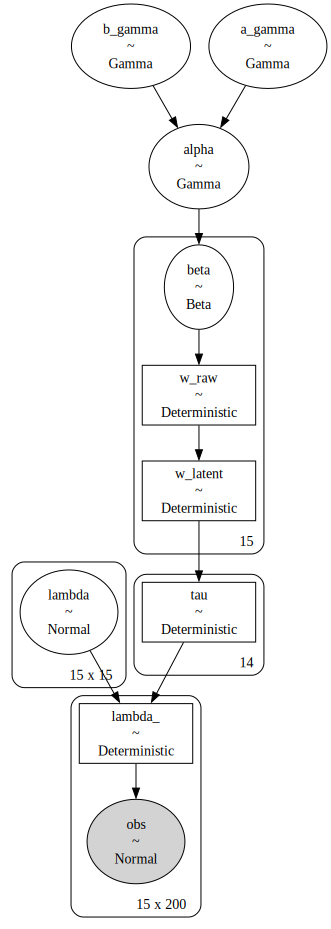

In [25]:
pm.model_to_graphviz(dpp_model)

In [26]:
n_chains = 50
n_samples = 10000
samples_per_chain = n_samples // n_chains

with dpp_model:
    dpp_trace = pm.sample(
                        nuts_sampler="numpyro",
                        tune = samples_per_chain,
                        draws = samples_per_chain,
                        target_accept = 0.95,
                        chains = n_chains,
                        cores = multiprocessing.cpu_count()
                        )

Only 200 samples in chain.
/home/abuzarmahmood/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:27.815123
Sampling...


Compiling.. :   0%|                                                                        | 0/400 [00:00<?, ?it/s]

  0%|                                                                                      | 0/400 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                        | 0/400 [00:00<?, ?it/s]


  0%|                                                                                      | 0/400 [00:00<?, ?it/s]


Compiling.. :   0%|                                                                        | 0/400 [00:00<?, ?it/s]



  0%|                                                                                      | 0/400 [00:00<?, ?it/s]



Compiling.. :   0%|                                                                        | 0/400 [00:00<?, ?it/s]




  0%|                                                                                      | 0/400 [00:00<?, ?it/s]




Compiling.. :   0%|                                 

Sampling time =  0:01:21.143950
Transforming variables...
Transformation time =  0:00:01.288922


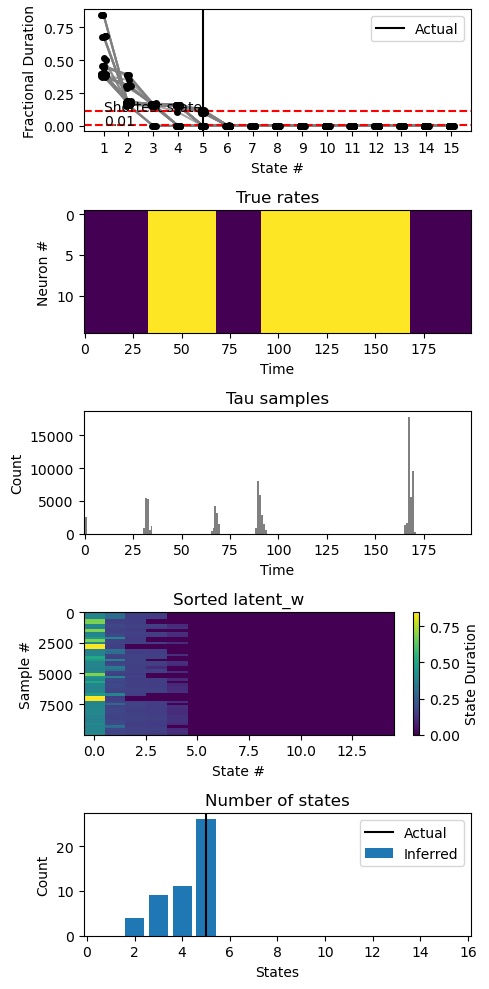

In [47]:
gen_plots.gen_dirichlet_plots(dpp_trace, true_r, n_chains, true_tau, length, n_states, max_states, figsize = (5,10))